In [38]:
from pycocotools.coco import COCO
import nltk
from data_loader import get_loader
from torchvision import transforms
from pathlib import Path
import json
import matplotlib.pyplot as plt
import skimage.io as io

from vocabulary import Vocabulary

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## files

First of all let's look at files that we have. We have (as we know) around `80K` training examples.

In [51]:
data_dir = Path.home() / 'data'

In [52]:
list(data_dir.glob('*'))

[PosixPath('/home/ilyarudyak/data/annotations'),
 PosixPath('/home/ilyarudyak/data/images')]

### images

In [53]:
list(data_dir.glob('images/*'))

[PosixPath('/home/ilyarudyak/data/images/train2014'),
 PosixPath('/home/ilyarudyak/data/images/test2014'),
 PosixPath('/home/ilyarudyak/data/images/val2014')]

In [54]:
len(list(data_dir.glob('images/train2014/*')))

82783

### captions

So we have about `5` captions for each image. They are stored in an arbitrary order.

In [55]:
list(data_dir.glob('annotations/captions*'))

[PosixPath('/home/ilyarudyak/data/annotations/captions_train2014.json'),
 PosixPath('/home/ilyarudyak/data/annotations/captions_val2014.json')]

In [56]:
data = json.load(open(data_dir / 'annotations/captions_train2014.json')) 

In [57]:
data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [58]:
len(data['images'])

82783

In [59]:
data['images'][0]

{'license': 5,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 16:28:13',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'id': 57870}

In [60]:
len(data['annotations'])

414113

In [61]:
414113 / 82783

5.0023917954169335

In [62]:
data['annotations'][0]

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

### indicies

For some reason `image_ids` are not consecutive. `image_id` contains in both an image description (as `id`) and a caption description (as `image_id`). Caption `id` contains in a caption description as `id`.

In [63]:
image_ids = [data['images'][i]['id'] for i in range(len(data['images']))]

In [67]:
min(image_ids), max(image_ids)

(9, 581921)

In [70]:
sorted(image_ids)[:5], sorted(image_ids)[-5:]

([9, 25, 30, 34, 36], [581903, 581904, 581906, 581909, 581921])

In [72]:
caption_ids = [data['annotations'][i]['id'] for i in range(len(data['annotations']))]

In [79]:
image_ids2 = list(set([data['annotations'][i]['image_id'] 
                       for i in range(len(data['annotations']))]))

In [73]:
len(caption_ids)

414113

In [75]:
min(caption_ids), max(caption_ids)

(26, 829719)

In [80]:
len(image_ids2)

82783

In [81]:
sorted(image_ids2)[:5], sorted(image_ids2)[-5:]

([9, 25, 30, 34, 36], [581903, 581904, 581906, 581909, 581921])

## vocabulary

And now let's have look at the vocabulary:

- we may provide `vocab_threshold` to manage our vocabulary size; for `vocab_threshold=4` its size is around `10K`;
- `Vocabulary` has operator overloading methods for `length` and `call` - see examples of using below; 
- as usual we have dictionaries `word2idx` and `idx2word`;

In [2]:
vocab = Vocabulary(vocab_threshold=4)

loading annotations into memory...
Done (t=1.80s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...


In [3]:
len(vocab)

9955

In [4]:
vocab('bathroom')

10

In [7]:
list(vocab.idx2word.items())[:5]

[(0, '<start>'), (1, '<end>'), (2, '<unk>'), (3, 'a'), (4, 'very')]

### coco

The main difference is that we're using `COCO` class from `pycocotools`. We build our dictionaries in the following manner:

- we extract all captions with `COCO` - see below;
- tokenize them using nltk and count using `Counter`;
- add a word to our dictionaries if its frequency is above the threshold;

In [8]:
vocab.annotations_file

PosixPath('/home/ilyarudyak/data/annotations/captions_train2014.json')

In [9]:
coco = COCO(vocab.annotations_file)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [12]:
type(coco.anns), len(coco.anns)

(dict, 414113)

In [14]:
list(coco.anns.items())[0]

(48,
 {'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'})

In [16]:
caption = coco.anns[48]['caption']

In [17]:
caption

'A very clean and well decorated empty bathroom'

What else can we do with `COCO`? Well, first of all we can get captions with standard `API`, not with using instance variables.

In [18]:
annIds = coco.getAnnIds()

In [20]:
type(annIds), len(annIds)

(list, 414113)

In [21]:
annIds[:5]

[48, 67, 126, 148, 173]

In [22]:
anns = coco.loadAnns(annIds)

In [23]:
type(anns), len(anns)

(list, 414113)

In [24]:
anns[0]

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

Let's get caption for an image:

- we may get a list of images if we provide their ids;
- we may get an image from an `url` using `skimage.io`;
- finally we have helper functions to exract all annotations for a given image;

In [30]:
img = coco.loadImgs(318556)

In [36]:
type(img), type(img[0])

(list, dict)

In [37]:
img[0]

{'license': 1,
 'file_name': 'COCO_train2014_000000318556.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000318556.jpg',
 'height': 640,
 'width': 480,
 'date_captured': '2013-11-15 05:00:35',
 'flickr_url': 'http://farm4.staticflickr.com/3133/3378902101_3c9fa16b84_z.jpg',
 'id': 318556}

In [40]:
I = io.imread(img[0]['coco_url'])

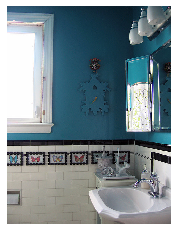

In [44]:
plt.imshow(I); plt.axis('off');

In [43]:
annIds = coco.getAnnIds(imgIds=img[0]['id']);
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

A very clean and well decorated empty bathroom
A blue and white bathroom with butterfly themed wall tiles.
A bathroom with a border of butterflies and blue paint on the walls above it.
An angled view of a beautifully decorated bathroom.
A clock that blends in with the wall hangs in a bathroom. 


## `CoCoDataset`

Let's first create the dataset (from dataloader) and see what we can get from it. Then we can analyze how it can be build. We have in the `dataset`:

- `Vocabulary` object;
- `COCO` object;
- `caption_lengths` - we compute length of all captions so we can be able to analyze their frequency with a `Counter`;
- we can get length of the dataset using operator overloading (it returns number of captions - length of `dataset.ids`;
- we can get image and caption (tensors) using another overloaded method;
- finally we don't use padding in this assignment, instead we choose captions of the same size to get a batch of data - **not** a usual solution;

In [45]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)


loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.68s)
creating index...


  0%|          | 835/414113 [00:00<00:49, 8349.25it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:49<00:00, 8413.49it/s]


In [46]:
dataset = data_loader.dataset

In [47]:
len(dataset.vocab)

8856

In [48]:
type(dataset.coco)

pycocotools.coco.COCO

In [49]:
len(dataset.ids)

414113

In [50]:
len(dataset)

414113

This concludes our debugging of data preparation in this assignment.